# Twitter Sentiment Analysis

## Introduction

**Sentiment Analysis:** Sentiment analysis deals with extracting the overtones found in text by classifying them as positive, neutral or negative using machine learning methods. It is widely used in many fields, for example in analyzing the voice of the customer or the overtones of social opinions. It is also known as opinion mining or emotion AI.

In this project we will try to develop Sentiment Analysis model which will classify tweets as positive or negative.

## Importing Dependencies


In [1]:
import warnings
warnings.simplefilter('ignore')


In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import re
from string import punctuation, digits
import time
from bs4 import BeautifulSoup

In [2]:
# pip install spacy
# pip install nltk
# !pip install wordcloud

In [3]:
from nltk.corpus import stopwords 
nltk_stop_words= stopwords.words('english') 

from spacy.lang.en.stop_words import STOP_WORDS
spacy_stop_words = STOP_WORDS

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
skn_stop_words = ENGLISH_STOP_WORDS

In [4]:
from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

from nltk.stem.porter import PorterStemmer 
stemmer = PorterStemmer()

In [5]:
# import nltk
# nltk.download('stopwords')

# nltk.download('punkt')

# nltk.download('wordnet')

# nltk.download('omw-1.4')

In [6]:
from wordcloud import WordCloud
from collections import Counter

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score, plot_confusion_matrix

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC 
from sklearn.naive_bayes import MultinomialNB 

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV

In [11]:
import pickle

## Importing dataset

The dataset used in project is sentiment140.
Data was downloaded from *http://help.sentiment140.com/for-students

Dataset contain 1,600,000 tweets, the main reason of using this data  was size and interesting approch of annoted sentiment.
Tweets was automaticly collect using Twitter Search API based on keyword search. More about this proces we can find in link above.
Most common approch to annotation tweet/text is making it manual by humans, in this dataset tweet sentiment was based on emoticons inside tweets. For exmaple ':)' emoticon define sentiment as positive and ':(' as negative.

Bulindg model based on that approch could bring lower accuracy compare to human annotation but it's worth to try and see results of almost zero cost of collecting and annotation tweets against to evpensive manual process.

Dataset contain only english tweets with out any emoticons.

The data is a CSV file.
Data file format contain 6 fields:
* 0 - the polarity of the tweet (0 = negative, 4 = positive)
* 1 - the id of the tweet 
* 2 - the date of the tweet 
* 3 - the query 
* 4 - the user that tweeted 
* 5 - the text of the tweet 

Original data have some issue with encoding so it was manualy changed to UTF-8 using other programs.

In [449]:
df= pd.read_csv('training.1600000.processed.noemoticon.encode.csv', header=None)

In [450]:
df.columns = ["sentiment", "id", "date", "query", "username", "text"]

In [451]:
df

,sentiment,id,date,query,username,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


<font size=3>To make sentiment analisys we need only labels with sentiment and text so we drop other columns from dataframe.

In [452]:
df.drop(['id','date','query','username'], axis=1, inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   text       1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


<font size=3>First of all we need to check is there any incomplete row in our data.

In [453]:
df.isnull().any() 

sentiment    False
text         False
dtype: bool

<font size=3>Just to unify the labels we will change '4'- positive sentiment to '1'.

In [454]:
df.sentiment.replace(4,1,inplace=True)

<font size=3>Lets chceck the distribution of sentiment.

In [455]:
df.sentiment.value_counts()

0    800000
1    800000
Name: sentiment, dtype: int64

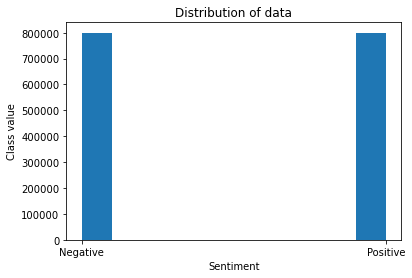

In [456]:
plt.hist(df.sentiment)
plt.title('Distribution of data')
plt.xticks([0,1],['Negative','Positive'])
plt.ylabel('Class value')
plt.xlabel('Sentiment')
plt.show()

<font size=3>With that large sized dataset it is posibble to have duplicated tweets so we need to check it.

In [457]:
print(f" Unique tweets : {len(df.text.unique())}")
print(f" Duplicated tweet number: {len(df.text)-len(df.text.unique())}")

 Unique tweets : 1581466
 Duplicated tweet number: 18534


<font size=3>It is no need to learn model something 'twice', it could lead to overfit so we need to delete duplicatet tweets.

In [458]:
df[df.text.duplicated()].index

Int64Index([   1940,    2149,    3743,    3746,    4163,    4490,    4961,
               5101,    5121,    5536,
            ...
            1599354, 1599377, 1599385, 1599440, 1599450, 1599501, 1599531,
            1599678, 1599768, 1599931],
           dtype='int64', length=18534)

In [459]:
df.drop(index=df[df.text.duplicated()].index, inplace=True)

In [460]:
df.shape

(1581466, 2)

<font size=3>Again we can chcek te distribution of sentiment

In [461]:
df.sentiment.value_counts()

1    791281
0    790185
Name: sentiment, dtype: int64

## Preprocess Text

**Text Preprocessing** is very important step for **Natural Language Processing** tasks.
In simple terms it involves changing the text from 'dirty' to 'clean' and from words to more understandable form for the computer, numbers. The cleaner the text, the machine learning algorithms should perform better and quicker.

 **The Preprocessing steps:**
1. **Replace html sings:** While working witch text it's find out there are some html sings in text, perhaps remaining after creating dataset by the authors. We will use BeautifulSoup library to try transfrom it to cleaner text version.
2. **Lower Casing:** All tweets will be converted to lowercase. It will help in next steps of cleaning and standardize words, ex. word *"Happy"* and *"happY"* are the same words but before lowercase algorithms will think there are two different.
3. **Remove #-tags:** Nowadays every internet posts, tweet etc. are full of #-tags. Trying analize #-tags is very dificult process becouse there are no strict rules of creating them. For example some user will type single word with it *#love* but mostly it's combination of couple words *#loveweekend*.It is hard to separate combination of wrods so in our approch we will remove whole words starting with *'#'*. 
4. **Remove Usernames:** Some tweets contains usernames starting with *'@'*, it not bring any information on sentiment so it will be removed.
5. **Remove URLS:** Many people attach links to websites in their tweets, again it do not bring information on sentiment. For example webstie with name of popular information portal do not bring information of sentiment because article in link can be negative or positive. URLs are more complex part of tweets beacuse it have many forms of typing. In our approach we will remove links starts with *'https:','www.'* and ends with *'.com'*.
6. **Remove RT:** *RT* corresponds to re-posting of a Tweet, sometimes people type *'RT'* at the beginning of a Tweet to indicate that they are re-posting someone else's content.
7. **Transform extended words:** It is common thing to type as one word multiple times phrase such as *'ha'* which brings in result *'hahahaha'* etc. We will try to transform it leaving two occurences, for example from *'hahaha'* to *'haha'*.
8. **Removing Consecutive letters:** Words with 3 of more consecutive letters will be replace by 2 letter. For example *'Hellllo' to 'Hello'*.
9. **Contractions transformation:** In english language there are many contractions such as *'aren't'* etc. We will transform it to based form. For example from *'aren't'* to *'are not'*. To achive that we will use prepared dictionary. 
10. **Abbreviations transformation:** Abbreviations in tweets and any other short type of messages in internet are very common. We will try to transform it to it's longer version trying bring some information to model. To achive that we will use prepared dictionary.
11. **Remove non-ASCII:** In this specific dataset they are many non-ASCII characters, most of them correspond to letter from other langugages. Authors of dataset while collecting tweets use function from tweeter API to collect only english tweets. It's look like it didn't work perfect, we can find whole tweets in other language or only some words in tweet. In our approach we will remove whole words containing even single non-ASCII character hoping to leave only english words. 
12. **Remove string punctuation and digits:** Punctuation and digits mostly do not bring any sentiment. It can make some dificulties for model to recognize words including them. For exmaple *'lovely'* and *'lovely!!!'*. As the exmaple show with out remove punctuaction we incrase size of our vocabulary and bring inncorect information to model.
13. **Tokenize words:** Tokenize words is simply spliting words creating list of words from tweet. It has couple function in our proces, first it will help in next steps of preproces (removing short wrods, removing stopwords and lemmatizing wrods) and second it will remove multiplie white spaces from tweet.
14. **Removing short words:** Thanks to tokenize we can easy check the lenght of words, short words as *'be','on'* etc. does not bring much meaning so we can remove it from text and achive better calculating preformance to nexts steps of process.
15. **Remove stopwords:** In every language there are list of words called Stopwords *(for example 'she','the')*. Stopwords are words which does not bring much meaning to sentence so also does not to sentiment, we will safely remove it without losing information. 
16. **Lemmatizing or Stemming:** This is final step of preprocesing text. Lemmatizing is process of transforming words to its base form, for exmaple *'worse'* to *'bad'*, *'great'* to *'good'*. Stemming algorithms work by cutting off the end or the beginning of the word for exmaple *'studies'* to *'studi'*.
17. **Join words** From previos step we receive list of words, we need to re join them into one string.

All steps from list above should leave necessary information and also reduce size of vocabulary used in models.

<font size=3>First we set two dictionary with abbreviations and contractions to future use in text transformation function

In [462]:
abbreviations = {
    "$" : "dollar",
    "€" : "euro",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired",
    "don\x89Ûªt": "do not",
    "I\x89Ûªm": "I am",
    "you\x89Ûªve": "you have",
    "it\x89Ûªs": "it is",
    "doesn\x89Ûªt": "does not",
    "It\x89Ûªs": "It is", 
    "Here\x89Ûªs": "Here is", 
    "I\x89Ûªve": "I have", 
    "can\x89Ûªt": "cannot", 
    "wouldn\x89Ûªt": "would not", 
    "That\x89Ûªs": "That is", 
    "You\x89Ûªre": "You are", 
    "Don\x89Ûªt": "Do not", 
    "Can\x89Ûªt": "Cannot", 
    "you\x89Ûªll": "you will", 
    "I\x89Ûªd": "I would", 
    "donå«t": "do not", 
    "some1": "someone", 
    "yrs": "years", 
    "hrs": "hours", 
    "2morow|2moro": "tomorrow", 
    "2day": "today",
    "4got|4gotten": "forget", 
    "b-day|bday": "b-day", 
}

In [463]:
contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "i am",
    "I've": "i have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that has",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
    "u":"you",
    "ur":"your",
    "n":"and",
    'bout':'about',
    "cn":"can",
    "hve":"have"
}

<font size=3>Now we create a dictionary of punctuation and digits.

In [464]:
pun_dict = {'0': ' ','1': ' ','2': ' ','3': ' ','4': ' ','5': ' ',
            '6': ' ','7': ' ','8': ' ','9': ' ','!': ' ','"': ' ',
            '#': ' ','$': ' ','%': ' ','&': ' ',"'": ' ','(': ' ',
            ')': ' ','*': ' ','+': ' ',',': ' ','-': ' ','.': ' ',
            '/': ' ',':': ' ',';': ' ','<': ' ','=': ' ','>': ' ',
            '?': ' ','@': ' ','[': ' ','\\': ' ',']': ' ','^': ' ',
            '_': ' ','`': ' ','{': ' ','|': ' ','}': ' ','~': ' '}

<font size=3>Let's create a function to preprocess text.

In [467]:
def text_transformation(txt):
    
    txt = BeautifulSoup(txt, 'lxml')
    txt = txt.get_text()
    txt = txt.lower()
    txt = re.sub(r'#\S+|@\S+|https?:\/\/\S+|\S+.com |rt ','',txt)
    txt = re.sub(r'www.?\S+','', txt) 
    txt = re.sub(r'\b[a-z]*?([a-z]{2,}?)\1+[a-z]*?\b','\\1\\1',txt)
    txt = re.sub(r"(.)\1\1+",r'\1\1',txt) 
    
    txt = txt.split()
    txt = [contractions[i] if i in contractions.keys() else i for i in txt]
    txt = [abbreviations[i] if i in abbreviations.keys() else i for i in txt]
    txt = [i for i in txt if not re.search('[^\x00-\x7F]',i)]
    
    txt = ' '.join(txt)
    txt = txt.translate(str.maketrans(pun_dict)) 

    
    token = word_tokenize(txt)
    
    token = [word for word in token if len(word)>2]
    
    
#     token = [word for word in token if not word in nltk_stop_words]
    token = [word for word in token if not word in spacy_stop_words]
#     token = [word for word in token if not word in skn_stop_words] 

#     token = [lemmatizer.lemmatize(word) for word in token]
    token = [stemmer.stem(word) for word in token]
    
    txt = ' '.join(token)
    
    return txt

<font size=3>First approach to transforming data is using PorterStemmer and Spacy stop words.

In [466]:
print(f"Lenght of specific library Stop Words:\nNLTK: {len(nltk_stop_words)}\nSPACY: {len(spacy_stop_words)}\nSklearn: {len(skn_stop_words)}")

Lenght of specific library Stop Words:
NLTK: 179
SPACY: 326
Sklearn: 318


<font size=3>We are ready to transform tweets.

In [468]:
%%time
df.text = df.text.apply(lambda x: text_transformation(x))

Wall time: 9min 9s


<font size=3>Let's check how function works.

In [469]:
df.text.head(20)

0                     bummer shoulda got david carr day
1     upset updat facebook text cri result school to...
2                  dive time ball manag save rest bound
3                             bodi feel itchi like fire
4                                             behav mad
5                                                  crew
6                                              need hug
7     hey long time ye rain bit bit laugh loud fine ...
8                                                  nope
9                                             que muera
10                         spring break plain citi snow
11                                            pierc ear
12                    bear watch thought loss embarrass
13                               count know talk anymor
14                           gun zac snyder doucheclown
15                          wish got watch miss premier
16    holli death scene hume sever watch film wri di...
17                                             f

<font size=3>After all cleaning proces we can check how many of tweets is gone.

In [470]:
df.text[df.text.apply(lambda x: len(x)<3)]

83           
191          
208          
249          
282          
           ..
1599707    ye
1599720      
1599811      
1599914      
1599993      
Name: text, Length: 18728, dtype: object

<font size=3> Empty rows do not bring any information so we need to delet it.

In [471]:
df.drop(index=df.text[df.text.apply(lambda x: len(x)<3)].index, inplace=True)

In [472]:
print(f'Positive tweets after cleaning proces: {len(df[df.sentiment==1])}')
print()
print(f'Negative tweets after cleaning proces: {len(df[df.sentiment==0])}')

Positive tweets after cleaning proces: 781104

Negative tweets after cleaning proces: 781634


 <font size=3>After all cleaning proces we recive dataset with an unequal class distribution so technically it is imbalanced. However, diffrence bettwen those class is so small it should not bring problem in classification.

## Analysing preprocessed data

<font size=3>Now we can try to visualize the most common words accordingly to their sentiment.
Before visualization we need to count occurence of wrods.

In [473]:
neg_sen = df.text[df['sentiment'] == 0]

In [474]:
pos_sen = df.text[df['sentiment'] == 1]

In [475]:
neg_words = ' '.join(neg_sen)

In [476]:
pos_words = ' '.join(pos_sen)

In [477]:
pos_c = Counter(pos_words.split())
neg_c = Counter(neg_words.split())

<font size=3>Now we can plot WordCloud which will show us the most occurence of words.

In [480]:
# wc = WordCloud(width=800, height=400, background_color='white').generate(pos_words)

# plt.figure(1,figsize=(13, 13))
# plt.imshow(wc)
# plt.title('Positive sentiment WordCloud')
# plt.axis('off')
# plt.show()

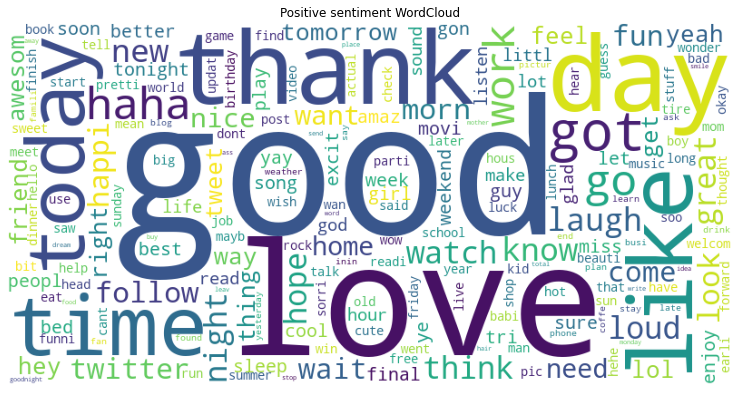

In [479]:
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(pos_c)

plt.figure(1,figsize=(13, 13))
plt.imshow(wc)
plt.title('Positive sentiment WordCloud')
plt.axis('off')
plt.show()

In [481]:
# wc = WordCloud(width=800, height=400, background_color='black').generate(neg_words)

# plt.figure(1,figsize=(13, 13))
# plt.imshow(wc)
# plt.title('Negative sentiment WordCloud')
# plt.axis('off')
# plt.show()

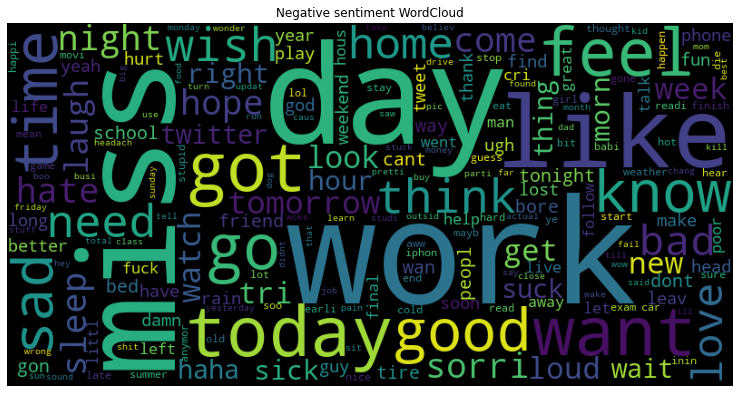

In [482]:
wc = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(neg_c)

plt.figure(1,figsize=(13, 13))
plt.imshow(wc)
plt.title('Negative sentiment WordCloud')
plt.axis('off')
plt.show()

<font size=3>Let's see fifteen most common words according to their sentiment

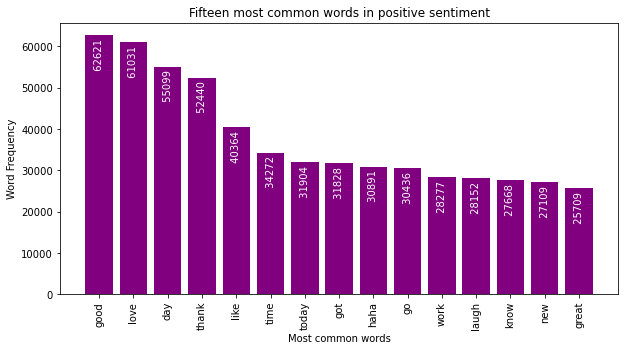

In [483]:
most_positive = dict(pos_c.most_common(15))
plt.figure(1,figsize=(10,5))
plt.bar(most_positive.keys(),most_positive.values(),color='purple')
plt.title('Fifteen most common words in positive sentiment')
plt.ylabel('Word Frequency')
plt.xlabel('Most common words')
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(pos_c.most_common(15)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top', color='white')
plt.show()

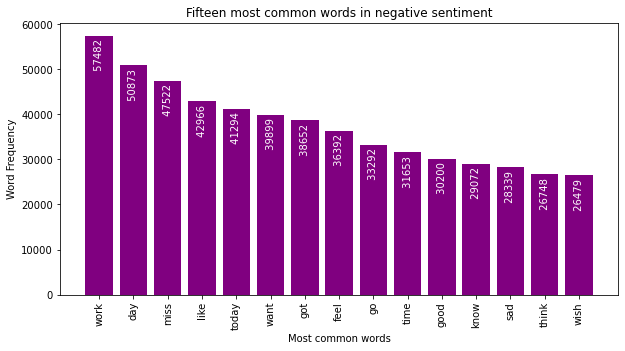

In [484]:
most_negative = dict(neg_c.most_common(15))
plt.figure(1,figsize=(10,5))
plt.bar(most_negative.keys(),most_negative.values(),color='purple')
plt.title('Fifteen most common words in negative sentiment')
plt.ylabel('Word Frequency')
plt.xlabel('Most common words')
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(neg_c.most_common(15)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top', color='white')
plt.show()

<font size=3>If we compare those two plots only first two/three words in some way corresponds to their sentiment striclty.
Looking further it looks like we have some similarity in words,
so with out taking context of using words we can not strictly say which sentiment are they.
This can cause problems in future model predictions. If the models do not find the right split points for a given sentiment using similar words, misleading predictions may occur.

## Creating and Evaluating Models

Now we will create 3 different model for our sentiment analysis problem.
We will use some baseline models from sklearn library according to our classification problem.

1. **Multinomial Naive Bayes - [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
2. **Linear Support Vector Classification - [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
3. **Logistic Regression - [LR](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

We will use Accuracy as our evaluation metric. Accuracy is the most commonly used and simple metric to evaluate how our machine learning model is doing. Accuracy is the ratio of the number of correct predictions made against the total number of predictions made. We should use it with balanced dataset, our data after cleaning isn't perfectly banalced, but the difference beetwen classes (530 piece beetwen class in 1.5M total) should not affect model accuracy.


Before fitting model, we need to change our tweets from strings to vectors.
We will use two approaches extracting features from text, commonly named as Bag of words - BOW.

1. [**CountVectorizer**:](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
 This method change our text into vector basis on the frequency (count) of each word that occurs in text.
2. [**TfidfVectorizer**:](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
 This method in simple words do not relay only on term frequency in document but also check the occurence of term across all documents and giving them their weights.

<font size=3>First we will try to look how our models works with default parametrs. 

We are creating two function depends on vectoraizer method.

Function will split the data, vectorize text, fit model, check the accuracy score,
also giving the time of fiting the model.


In [485]:
def base_models_count(model,X,y):
    X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123, stratify=y)
    
    
    vec = CountVectorizer()
    train_bow = vec.fit_transform(X_train)
    test_bow = vec.transform(X_test)
    
    model = model
    t0 = time.time()
    model.fit(train_bow,y_train)
    t1 = time.time()
    y_pred = model.predict(test_bow)
    accuracy = accuracy_score(y_test, y_pred)
    fit_time = t1-t0
    
    return accuracy,fit_time
    

In [486]:
def base_models_tfidf(model,X,y):
    X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123, stratify=y)
    
    
    vec = TfidfVectorizer()
    train_bow = vec.fit_transform(X_train)
    test_bow = vec.transform(X_test)
    
    model = model
    t0 = time.time()
    model.fit(train_bow,y_train)
    t1 = time.time()
    y_pred = model.predict(test_bow)
    accuracy = accuracy_score(y_test, y_pred)
    fit_time = t1-t0
    
    return accuracy,fit_time

<font size=3>We will use function above in loop so before that we are creating list of models.

In [487]:
models = [LinearSVC(random_state=42),
          LogisticRegression(random_state=42, n_jobs=10),
          MultinomialNB()]

In [490]:
result_count = {}
for model in models:
    str_model = re.sub(r'\([^)]*\)',r'',str(model))
    
    accuracy,fit_time = base_models_count(model,df.text,df.sentiment)
    
    result_count[str_model] = {'accuracy':accuracy,'fit time':fit_time}

print(pd.DataFrame.from_dict(result_count))

           LinearSVC  LogisticRegression  MultinomialNB
accuracy    0.759535            0.764571       0.757813
fit time  204.541830            9.258021       0.154582


In [491]:
result_tfidf = {}
for model in models:
    str_model = re.sub(r'\([^)]*\)',r'',str(model))
    
    accuracy,fit_time = base_models_tfidf(model,df.text,df.sentiment)
    
    result_tfidf[str_model] = {'accuracy':accuracy,'fit time':fit_time}

print(pd.DataFrame.from_dict(result_tfidf))

          LinearSVC  LogisticRegression  MultinomialNB
accuracy   0.760334            0.767146       0.751238
fit time  12.487874            9.372154       0.160719


<font size=3>As we can see above in results using default parametrs, brings very similiar prediction strenght to each model.
It seems that LogisticRegression is better then others but the score value isn't dramatically bigger.
Main diffrence beetwen models is fitting time, quicker and giving better results is TFIDF. If the only factor of choise is time we should consider MultinomialNB as best model.

<font size=3>In next steps we will try to find the best parametrs for each model, then make closer look to results. 

<font size=3>Before we go to model tuning, let's chcek how n-gram paramter from vectoraizer affect on scores and possible overfitting the models.</font>

1. (1, 1) means only unigrams
2. (1, 2) means unigrams and bigrams
3. (2, 2) means only bigrams



In [549]:
X_train,X_test, y_train, y_test = train_test_split(df.text,df.sentiment,test_size=0.05,random_state=123, stratify=df.sentiment)

In [368]:
n_gram_range = [(1,1),(1,2),(2,2)]
models = [LogisticRegression(max_iter=5000),LinearSVC(max_iter=5000),MultinomialNB()]

In [134]:
for model in models:
    for n_gram in n_gram_range:
        vectoraizer = CountVectorizer(ngram_range=n_gram)
        X_train_vec = vectoraizer.fit_transform(X_train)
        X_test_vec = vectoraizer.transform(X_test)
        clf = model
        clf.fit(X_train_vec, y_train)
        print('--------------------')
        print(f' Fitted {model} using CountVectorizer with {n_gram} n-gram.')
        print(f' test set score {clf.score(X_test_vec,y_test)}')
        print(f' train set score {clf.score(X_train_vec,y_train)}')
        print('--------------------')  

--------------------
 Fitted LogisticRegression(max_iter=5000) using CountVectorizer with (1, 1) n-gram.
 test set score 0.767344535879289
 train set score 0.7899199852350901
--------------------
--------------------
 Fitted LogisticRegression(max_iter=5000) using CountVectorizer with (1, 2) n-gram.
 test set score 0.7788115745421503
 train set score 0.9230325185016042
--------------------
--------------------
 Fitted LogisticRegression(max_iter=5000) using CountVectorizer with (2, 2) n-gram.
 test set score 0.7159860245466296
 train set score 0.9223198691096126
--------------------
--------------------
 Fitted LinearSVC(max_iter=5000) using CountVectorizer with (1, 1) n-gram.
 test set score 0.7610095089394269
 train set score 0.8027106272998603
--------------------
--------------------
 Fitted LinearSVC(max_iter=5000) using CountVectorizer with (1, 2) n-gram.
 test set score 0.7598064937225643
 train set score 0.9696558199812609
--------------------
--------------------
 Fitted Linea

In [135]:
for model in models:
    for n_gram in n_gram_range:
        vectoraizer = TfidfVectorizer(ngram_range=n_gram)
        X_train_vec = vectoraizer.fit_transform(X_train)
        X_test_vec = vectoraizer.transform(X_test)
        clf = model
        clf.fit(X_train_vec, y_train)
        print('--------------------')
        print(f' Fitted {model} using TfidfVectorizer with {n_gram} n-gram.')
        print(f' test set score {clf.score(X_test_vec,y_test)}')
        print(f' train set score {clf.score(X_train_vec,y_train)}')
        print('--------------------')

--------------------
 Fitted LogisticRegression(max_iter=5000) using TfidfVectorizer with (1, 1) n-gram.
 test set score 0.769136260670361
 train set score 0.784912579204783
--------------------
--------------------
 Fitted LogisticRegression(max_iter=5000) using TfidfVectorizer with (1, 2) n-gram.
 test set score 0.780910452154549
 train set score 0.8465399120706506
--------------------
--------------------
 Fitted LogisticRegression(max_iter=5000) using TfidfVectorizer with (2, 2) n-gram.
 test set score 0.7199278190869882
 train set score 0.8793547896034019
--------------------
--------------------
 Fitted LinearSVC(max_iter=5000) using TfidfVectorizer with (1, 1) n-gram.
 test set score 0.7617134008216337
 train set score 0.8010893162539968
--------------------
--------------------
 Fitted LinearSVC(max_iter=5000) using TfidfVectorizer with (1, 2) n-gram.
 test set score 0.7665766538259723
 train set score 0.956987769777873
--------------------
--------------------
 Fitted LinearSV

<font size=3>As we can see in every case wehen we are using something else than unigram, models tends to overfits.
Probably we can handle that problem using diffrent than default regularization in models (C=1) or alpha value in NB, but to simplify future calculation and save some computation time we will use only unigrams.

## Creating Pipline to GridSearchCV

[**GridSearchCV**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) is the process of performing hyperparameter tuning in order to determine the optimal values for a given model.

[**Pipline**](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) in simple words is list of transformers and at last place on it estimator. The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.


We will use both of Bag of Words method with similiar paramters:
In both of them we leave default **n_gram range** as (1,1) means only unigrams, also in both we will try diffrent **max_df** range.

**max_df**: have influance on building the vocabulary, it ignore terms that have a document frequency strictly higher than the given threshold.

In addition to tfidf we will use **smooth_idf** and **sublinear_tf**.

**smooth_idf**: weights by adding one to document frequencies, as if an extra document was seen containing every term in the collection exactly once. 
**sublinear_tf**: Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf).

In LogisticRegression we will use *'liblinear'* solver because of possibility to check both of penalty *'l1','l2'*, besides those two we will set list of numbers responsible of regularization **('C' parametr).**
*
In LinearSVC like in LogisticRegression we will use diffrent regularization paramters **('C' parametr).**

In MultinomialNB we will set list of numbers responsible of additive smoothing. **('Alpha' paramter).**


In [245]:
X_train,X_test,y_train,y_test = train_test_split(df.text,df.sentiment,test_size=0.05,random_state=123, stratify=df.sentiment)

In [259]:
vectoraizer = [('vect_t',TfidfVectorizer()),('vect_c',CountVectorizer())]

In [284]:
models = [('log',LogisticRegression(n_jobs=8,random_state=42,max_iter=5000)),
          ('svc',LinearSVC()),
          ('nb',MultinomialNB())]

log_params =  {'log__solver': ['liblinear'],
              'log__penalty': ['l1','l2'],
              'log__C':[0.001, 0.01, 0.1 ,1, 10]}  # 100

svc_params = {'svc__C':[0.001, 0.01, 0.1, 1, 10]} # 100

nb_params = {'nb__alpha':[0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1]}

params = [log_params,svc_params,nb_params]

In [290]:
vect_params_c= {'vect_c__max_df': [0.7,0.8,0.9,1]}

vect_params_t= {'vect_t__sublinear_tf': [True,False],
              'vect_t__smooth_idf': [True,False],
              'vect_t__max_df': [0.7,0.8,0.9,1]}

In [292]:
gridcv_models_2 = {}
for vec in vectoraizer:
    for model, param in zip(models,params):
        name = f'{model[0]} {str(vec[1])[:5]}-2'
        if vec[0] == 'vect_t':
            par_t = {}
            par_t.update(vect_params_t)
            par_t.update(param)
            gridcv_models_2[name]=GridSearchCV(Pipeline([vec,model])
                                                ,par_t,cv=5,verbose=10,
                                                 n_jobs=10,scoring='accuracy',
                                                 error_score='raise')
        else:
            par_c = {}
            par_c.update(vect_params_c)
            par_c.update(param)
            gridcv_models_2[name]=GridSearchCV(Pipeline([vec,model])
                                                ,par_c,cv=5,verbose=10,
                                                 n_jobs=10,scoring='accuracy',
                                                 error_score='raise')
           

In [293]:
gridcv_models_2

{'log Tfidf-2': GridSearchCV(cv=5, error_score='raise',
              estimator=Pipeline(steps=[('vect_t', TfidfVectorizer()),
                                        ('log',
                                         LogisticRegression(max_iter=5000,
                                                            n_jobs=8,
                                                            random_state=42))]),
              n_jobs=10,
              param_grid={'log__C': [0.001, 0.01, 0.1, 1, 10],
                          'log__penalty': ['l1', 'l2'],
                          'log__solver': ['liblinear'],
                          'vect_t__max_df': [0.7, 0.8, 0.9, 1],
                          'vect_t__smooth_idf': [True, False],
                          'vect_t__sublinear_tf': [True, False]},
              scoring='accuracy', verbose=10),
 'svc Tfidf-2': GridSearchCV(cv=5, error_score='raise',
              estimator=Pipeline(steps=[('vect_t', TfidfVectorizer()),
                                

In [294]:
%%time
for model_name, model in gridcv_models_2.items():
    model.fit(X_train,y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 160 candidates, totalling 800 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Wall time: 2h 38min 4s


<font size=3>To future use we can save our models using Pickle library.

In [295]:
%%time
for model_name, model in gridcv_models_2.items():
    pickle_name = model_name+'.sav'
    pickle.dump(model, open(pickle_name, 'wb'))

Wall time: 216 ms


## Model evalution

<font size=3>Now when we have all Gridsearch result, we can try to find out which model 'is the best'.
First we will check which paramters were choosen by GS.

In [497]:
for grid_model_name, grid_model in gridcv_models_2.items():
    print('---------------')
    print(grid_model_name)
    print(grid_model.best_params_)
    print('---------------')

---------------
log Tfidf-2
{'log__C': 1, 'log__penalty': 'l2', 'log__solver': 'liblinear', 'vect_t__max_df': 0.7, 'vect_t__smooth_idf': True, 'vect_t__sublinear_tf': True}
---------------
---------------
svc Tfidf-2
{'svc__C': 0.1, 'vect_t__max_df': 0.7, 'vect_t__smooth_idf': True, 'vect_t__sublinear_tf': True}
---------------
---------------
nb Tfidf-2
{'nb__alpha': 1, 'vect_t__max_df': 0.7, 'vect_t__smooth_idf': True, 'vect_t__sublinear_tf': True}
---------------
---------------
log Count-2
{'log__C': 1, 'log__penalty': 'l1', 'log__solver': 'liblinear', 'vect_c__max_df': 0.7}
---------------
---------------
svc Count-2
{'svc__C': 0.01, 'vect_c__max_df': 0.7}
---------------
---------------
nb Count-2
{'nb__alpha': 1, 'vect_c__max_df': 0.7}
---------------


<font size=3>As we can see there are couple similarities in our best models, in all cases best max_df is set to  0.7. 
All tfidf models use smooth_idf and sublinear_tf approach.
Main diffrence beetwen Logistic regresion and LinearSVC is strenght of regularizatrion paramter, where svc have lower number so it means need stronger regularization. 
Alpha parametr in Naive Bayes refers to smoothing strenght (0 for no smoothing), as default it is set to 1 and gridsearch also set it to 1 so NB needs stronger smoothing.

<font size=3>Now will check is there any under- or over- fitting in results. To do this we compare accuracy scores on test and training dataset.

In [297]:
for model_name, model in gridcv_models_2.items():
    print('------------------------')
    print(model_name)
    print(model.score(X_test,y_test))
    print(model.score(X_train,y_train))
    print('------------------------')

------------------------
log Tfidf-2
0.7694562115259096
0.7851220630997824
------------------------
------------------------
svc Tfidf-2
0.7687267235752588
0.7844862020165687
------------------------
------------------------
nb Tfidf-2
0.7524220279765028
0.7785573362809267
------------------------
------------------------
log Count-2
0.7677412749401692
0.7784562990325347
------------------------
------------------------
svc Count-2
0.7676004965637279
0.7733411199372761
------------------------
------------------------
nb Count-2
0.7591665920114671
0.779600040684332
------------------------


<font size=3>**Underfitting** is situatnion when model is unable to make classification neither on traing data nor test. For example when accuracy score on train data is 50%. Our models have above 70% of accuracy so we can safly assume that there is no underfitting.

<font size=3>**Overfitting** refers to a model that models the training data too well. Again we can use accuracy to decet this, when accuracy score on traing data is significantly bigger than test data we can say model overfits. When we look on numbers, safe diffrence beetween test and train score is 5% (ex. 70% test, 75% train), in some paper's it is even 10%. Diffrence beetwen scores in our models is maximum 2%, so we assume there is no overfitting. 

<font size=3>Another information from scores above is that there is almost no diffrence which Bag of Word method we choose because scores are almost the same. In this case choosing method could be based on time of computation which is lower using TfidfVectoraizer. But time shouldn't be only factor of decission. 

<font size=3>When we compare scores beetwen classification models, again there is no big diffrence beetwen them. It is look like first is LogisticRegression then LinearSVC and last MultinomialNB with maximum 2% diffrence beetwen them form first to last. Again we can look on computation time (from base_model function), SVC and LogisticRegression have almost the same time (using Tfidf) when MultinomialNB is more than 50 times quicker then the others.

<font size=3>In text classification problems the gol is to predict the correct label(y) of sample(x). Choosing apropriate model to problem cloud be define by how model predict specific label, ex. Spam to Non-Spam. To check that we are using metrics such as precision,recall, f1-score.

<font size=3>**Precision** is the ratio of accurately predicted positive observations to total expected positive observations is known as precision. 

<font size=3>**Recall** is defined as the proportion of accurately predicted positive observations to all observations in the class. 

<font size=3>**F1-score** is a measure of a model’s accuracy on a dataset. It is used to evaluate binary classification systems, which classify examples into 'positive' or 'negative'. F-score is a way of combining the precision and recall of the model, and it is defined as the harmonic mean of the model’s precision and recall.</font>

<font size=3>To check those metrics we will use classification_report method from sklearn library, but before that we will plot confusion matrix (also from sklearn) on each model to show True Positive,True Negative,False Postive,False Negative predictions in model.

In [360]:
models_ = ['LogisticRegression TfidfVectorizer',
 'LinearSVC TfidfVectorizer',
 'MultinomialNB TfidfVectorizer',
 'LogisticRegression CountVectorizer',
 'LinearSVC CountVectorizer',
 'MultinomialNB CountVectorizer']

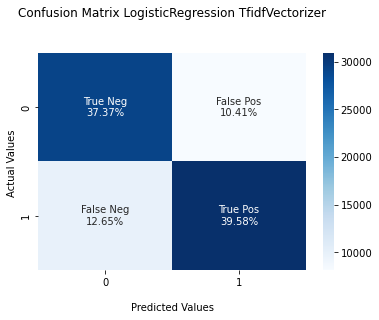

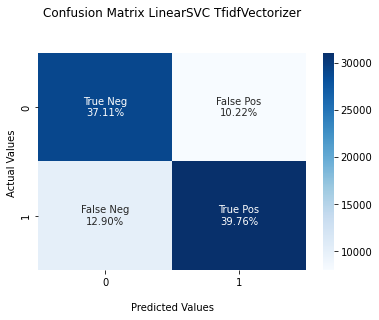

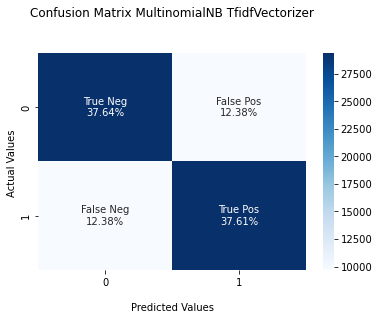

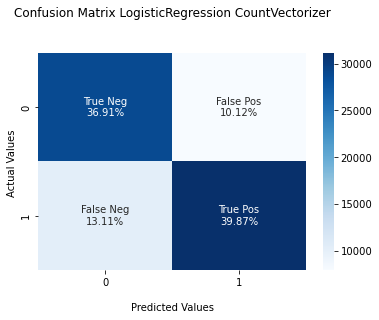

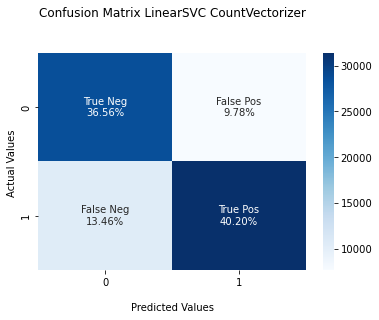

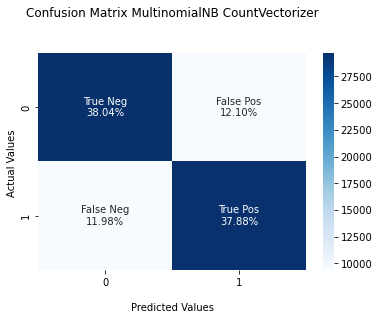

In [364]:
for model, model_name_ in zip(gridcv_models_2.values(),models_):

    y_pred = model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_pred,y_test)
    
    names = ['True Neg','False Pos','False Neg','True Pos']
    percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(names,percentages)]
    
    labels = np.asarray(labels).reshape(2,2)
    
    ax = sns.heatmap(cf_matrix, annot=labels, 
                fmt='', cmap='Blues')
    
    ax.set_title(f'Confusion Matrix {model_name_}\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    
    ax.xaxis.set_ticklabels([0,1])
    ax.yaxis.set_ticklabels([0,1])
    
    plt.show()

<font size=3>
We can split our models in two groups looking for similarities in predictions.

Logistic regression and LinearSVC makes almost the same predictions, both predicts better positive sentiment than negative, when MultinomialNB have almost equal scores on both class.

However 'better' isn't that obvious when we handle clasification problem. 

Depending on the set goal we want to achieve we will aim to maximize a different value. e.g. Suppose we want to evaluate the tweets of politicians and check their sentiment. Journalists will want to get the most objective evaluation of tweets ( without omitting any), the electoral staff of this politician will focus mainly on the correct detection of positive statements, while the opposition will want to find all the negative ones.

**Journalists**  want to maximaize recall metric on both class to not ommit anything.

**Political staff**  want to maximaize recall metric in positive class to show every positive tweet from politician.

**Opposition**  want to maximaze recall metric in negative class to show voters all negative tweet.
(it's brutal but true...)

Take a closer look on precision and recall.</font>

In [362]:
for model_name, model in gridcv_models_2.items():
    print('------------------------')
    print(model_name)
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))
    print('------------------------')

------------------------
log Tfidf-2
              precision    recall  f1-score   support

           0       0.78      0.75      0.76     39082
           1       0.76      0.79      0.77     39055

    accuracy                           0.77     78137
   macro avg       0.77      0.77      0.77     78137
weighted avg       0.77      0.77      0.77     78137

------------------------
------------------------
svc Tfidf-2
              precision    recall  f1-score   support

           0       0.78      0.74      0.76     39082
           1       0.75      0.80      0.77     39055

    accuracy                           0.77     78137
   macro avg       0.77      0.77      0.77     78137
weighted avg       0.77      0.77      0.77     78137

------------------------
------------------------
nb Tfidf-2
              precision    recall  f1-score   support

           0       0.75      0.75      0.75     39082
           1       0.75      0.75      0.75     39055

    accuracy          

<font size=3>
- If we want to choose model for jurnalist we should consider MultinomialNB, in every case precision and recall in both classes are the same,
so the results in some way could be more objective but with less accuracy in general detection. 

<font size=3>
- In other two models the recall score on positve class is much better than negative so maybe those two models will find usage in political staff. The precision of detection is lower compare to precision in negative sentiment but higher recall will help to not ommit any possible positive tweet from our politician. </font>

<font size=3>
- F1- score is mostly use when we want comapre couple models with very difrrent precision and recall scores, we seem to have some pattern in scores so recall and precision is better, f1-score in our situation only tells that LogisticReg. and LinearSVC have higher mean score so we should consider use those two models against to MultinomialNB 
    
    

<font size=4>Predictions on random text

<font size=3>As a reminder: 
* 0 - negative sentiment
* 1- positive sentimen

In [621]:
text_sample = 'Today was a great day!!'
text_sample = [text_transformation(text_sample)]

print(f"LinearSVC prediction: {gridcv_models_2['svc Tfidf-2'].predict(text_sample)} ")
print(f"LogisticRegresion prediction: {gridcv_models_2['log Tfidf-2'].predict(text_sample)} ")
print(f"MultinomialNB prediction: {gridcv_models_2['nb Tfidf-2'].predict(text_sample)} ")

LinearSVC prediction: [1] 
LogisticRegresion prediction: [1] 
MultinomialNB prediction: [1] 


In [622]:
text_sample_2 = 'Today was not good day!!'
text_sample_2 = [text_transformation(text_sample_2)]

print(f"LinearSVC prediction: {gridcv_models_2['svc Tfidf-2'].predict(text_sample_2)} ")
print(f"LogisticRegresion prediction: {gridcv_models_2['log Tfidf-2'].predict(text_sample_2)} ")
print(f"MultinomialNB prediction: {gridcv_models_2['nb Tfidf-2'].predict(text_sample_2)} ")

LinearSVC prediction: [1] 
LogisticRegresion prediction: [1] 
MultinomialNB prediction: [1] 


<font size=3>As we can see above first predictions was right, against to second. BOW Models were learnd only on unigrams. As we remember from occurence visualization words like 'day', 'today' was very common in both sentiment an probably model gave them close meaning to both sentiment. When we use unigram, model learned and classify every word separetly so it does not understand that words 'not' and 'good' together have different meaning in sentence. To improve predictions in this situation we should consider building BOW model using unigram and bigram approach, then model will learn every word separetly and together. 

In [623]:
text_sample_3 = 'Today was terrible day!!'
text_sample_3 = [text_transformation(text_sample_3)]

print(f"LinearSVC prediction: {gridcv_models_2['svc Tfidf-2'].predict(text_sample_3)} ")
print(f"LogisticRegresion prediction: {gridcv_models_2['log Tfidf-2'].predict(text_sample_3)} ")
print(f"MultinomialNB prediction: {gridcv_models_2['nb Tfidf-2'].predict(text_sample_3)} ")

LinearSVC prediction: [0] 
LogisticRegresion prediction: [0] 
MultinomialNB prediction: [0] 


<font size=3>When we replace thoes two words strictly describing emotions 'not good' to one word 'terrible', models starts to make good predictions.

In [624]:
text_sample_4 = "We've been eating pizza every Friday for almost two years now"
text_sample_4 = [text_transformation(text_sample_4)]

print(f"LinearSVC prediction: {gridcv_models_2['svc Tfidf-2'].predict(text_sample_4)} ")
print(f"LogisticRegresion prediction: {gridcv_models_2['log Tfidf-2'].predict(text_sample_4)} ")
print(f"MultinomialNB prediction: {gridcv_models_2['nb Tfidf-2'].predict(text_sample_4)} ")

LinearSVC prediction: [1] 
LogisticRegresion prediction: [1] 
MultinomialNB prediction: [1] 


In [625]:
text_sample_5 = 'The Palace of Culture and Science is located in Warsaw next to the Congress Hall'
text_sample_5 = [text_transformation(text_sample_5)]

print(f"LinearSVC prediction: {gridcv_models_2['svc Tfidf-2'].predict(text_sample_5)} ")
print(f"LogisticRegresion prediction: {gridcv_models_2['log Tfidf-2'].predict(text_sample_5)} ")
print(f"MultinomialNB prediction: {gridcv_models_2['nb Tfidf-2'].predict(text_sample_5)} ")

LinearSVC prediction: [1] 
LogisticRegresion prediction: [1] 
MultinomialNB prediction: [1] 


<font size=3>Sample 4 and 5 represent neutral sentiment but as we said before our models do not learn that so the predictions are wrong.

In [626]:
text_sample_6 = 'Today was the worst day of my life!!'
text_sample_6 = [text_transformation(text_sample_6)]

print(f"LinearSVC prediction: {gridcv_models_2['svc Tfidf-2'].predict(text_sample_6)} ")
print(f"LogisticRegresion prediction: {gridcv_models_2['log Tfidf-2'].predict(text_sample_6)} ")
print(f"MultinomialNB prediction: {gridcv_models_2['nb Tfidf-2'].predict(text_sample_6)} ")

LinearSVC prediction: [0] 
LogisticRegresion prediction: [0] 
MultinomialNB prediction: [0] 


In [628]:
text_sample_7 = 'I fell very sad!!'
text_sample_7 = [text_transformation(text_sample_7)]

print(f"LinearSVC prediction: {gridcv_models_2['svc Tfidf-2'].predict(text_sample_7)} ")
print(f"LogisticRegresion prediction: {gridcv_models_2['log Tfidf-2'].predict(text_sample_7)} ")
print(f"MultinomialNB prediction: {gridcv_models_2['nb Tfidf-2'].predict(text_sample_7)} ")

LinearSVC prediction: [0] 
LogisticRegresion prediction: [0] 
MultinomialNB prediction: [0] 


<font size=3>Finally when change sentence using most negative emotions models predicts well.

<font size=3>As examples above proved our models isn't perfect and probalby we shouldn't consider use it to make some important decissions until some improvment.

## Summary 

<font size=3>
Text preprocessing have major impact on text classifiaction models prediction strenght.
Our approch to text cleaning and use metrics show that if we focus more on accuracy and specific precision and recall score
we should consider to choose Logistic Regresion or LinearSVC model.
However if we focus mostly on computation time and accept lower accuracy we should consider MultinomialNB.

Text cleaning is very dificult task, internet posts like tweets are one of 'dirtiest' group.
Users very often do not care about proper writing, they are using a lot of abbreviations etc.

Our cleaning function do not handle some problems of misspeling or do not convert in anyway emoticons from tweets.
Adding in future some spellchecker function could reduce the size o vocabulary and increase classfication accuracy giving bigger weights to correctly write words. There are many prepare spellchecker in python libraly with different effectiveness, so we could try some of them or try to create own function based on Levenshtein distance.


We do not apllay from start any emoticons conversion because our dataframe do not contain it. Even if we try to applay that approch ( e.x. change ':)' to word 'smile') we do not fit our model with that kind of information. Emoticons brings very diffrent emotions so there are many different words to discribe it, if we even use that conversion we are not 100% sure that model learned appropriate word with proper weight to make prediction.


Another change in future project is trying to use different Stemming and lemmatization algorithm with other stop words set.


Because of data limitations we do not handle at all neutral sentiment, so neutral tweet's or tweet's including sarcasm will always have bad predictions. 


Our model do not handle properly with double words describing emotions like 'not good', in future we can try to manage that problem with different n-gram range in BOW model.



Another weakness of our model could be approch to making labels in training data. As paper about dataset said, when they find smile/sad emoticon in tweet they set label as posivite/negative, it's simple approch but when we consider that not every 'smile' in tweet should mean that it's positive sentence we learn our model wrong pattern.
For ex. 'I love you so much :(......' words in that sentce say something positive but when we see sad face and dots we could assume that user feels bad, label will be negative, but when we change emoticon 'I love you so much :))' we recive the same word pattern with two different label.
    
At last we could try use different clasification models, such as Decision Tree, Rain Forest or simple neural network.
</font>


<font size=3>To future improvment we can quickly check is unigram+bigram brings better accuracy, in this qucik experiment we add to GS n_gram range (1,2), and we use nltk stop words and lemmatizer in preprecosing text function.

In [428]:
X_train,X_test,y_train,y_test = train_test_split(df.text,df.sentiment,test_size=0.05,random_state=123, stratify=df.sentiment)

In [429]:
vectoraizer = [('vect_t',TfidfVectorizer()),('vect_c',CountVectorizer())]

In [430]:
models = [('log',LogisticRegression(n_jobs=8,random_state=42,max_iter=5000)),
          ('svc',LinearSVC()),
          ('nb',MultinomialNB())]

log_params =  {'log__solver': ['liblinear'],
              'log__penalty': ['l1','l2'],
              'log__C':[0.001, 0.01, 0.1 ,1]}

svc_params = {'svc__C':[0.001, 0.01, 0.1, 1]} 

nb_params = {'nb__alpha':[0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1]}

params = [log_params,svc_params,nb_params]

In [431]:
vect_params_c= {'vect_c__max_df': [0.7,0.8,0.9,1],
               'vect_c__ngram_range':[(1,1),(1,2)]}

vect_params_t= {'vect_t__sublinear_tf': [True,False],
              'vect_t__smooth_idf': [True,False],
              'vect_t__max_df': [0.7,0.8,0.9,1],
                'vect_t__ngram_range':[(1,1),(1,2)]}

In [432]:
gridcv_models_3 = {}
for vec in vectoraizer:
    for model, param in zip(models,params):
        name = f'{model[0]} {str(vec[1])[:5]}-lemm'
        if vec[0] == 'vect_t':
            par_t = {}
            par_t.update(vect_params_t)
            par_t.update(param)
            gridcv_models_3[name]=GridSearchCV(Pipeline([vec,model])
                                                ,par_t,cv=5,verbose=10,
                                                 n_jobs=10,scoring='accuracy',
                                                 error_score='raise')
        else:
            par_c = {}
            par_c.update(vect_params_c)
            par_c.update(param)
            gridcv_models_3[name]=GridSearchCV(Pipeline([vec,model])
                                                ,par_c,cv=5,verbose=10,
                                                 n_jobs=10,scoring='accuracy',
                                                 error_score='raise')
           

In [433]:
gridcv_models_3

{'log Tfidf-lemm': GridSearchCV(cv=5, error_score='raise',
              estimator=Pipeline(steps=[('vect_t', TfidfVectorizer()),
                                        ('log',
                                         LogisticRegression(max_iter=5000,
                                                            n_jobs=8,
                                                            random_state=42))]),
              n_jobs=10,
              param_grid={'log__C': [0.001, 0.01, 0.1, 1],
                          'log__penalty': ['l1', 'l2'],
                          'log__solver': ['liblinear'],
                          'vect_t__max_df': [0.7, 0.8, 0.9, 1],
                          'vect_t__ngram_range': [(1, 1), (1, 2)],
                          'vect_t__smooth_idf': [True, False],
                          'vect_t__sublinear_tf': [True, False]},
              scoring='accuracy', verbose=10),
 'svc Tfidf-lemm': GridSearchCV(cv=5, error_score='raise',
              estimator=Pipeline(s

In [434]:
%%time
for model_name, model in gridcv_models_3.items():
    model.fit(X_train,y_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Fitting 5 folds for each of 128 candidates, totalling 640 fits
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Wall time: 5h 43min 10s


In [435]:
for model_name, model in gridcv_models_3.items():
    pickle_name = model_name+'.sav'
    pickle.dump(model, open(pickle_name, 'wb'))

<font size=3>Checking the best params. 


In [443]:
for grid_model_name, grid_model in gridcv_models_3.items():
    print('---------------')
    print(grid_model_name)
    print(grid_model.best_params_)
    print('---------------')

---------------
log Tfidf-lemm
{'log__C': 1, 'log__penalty': 'l2', 'log__solver': 'liblinear', 'vect_t__max_df': 0.7, 'vect_t__ngram_range': (1, 2), 'vect_t__smooth_idf': True, 'vect_t__sublinear_tf': True}
---------------
---------------
svc Tfidf-lemm
{'svc__C': 0.1, 'vect_t__max_df': 0.7, 'vect_t__ngram_range': (1, 2), 'vect_t__smooth_idf': True, 'vect_t__sublinear_tf': True}
---------------
---------------
nb Tfidf-lemm
{'nb__alpha': 1, 'vect_t__max_df': 0.7, 'vect_t__ngram_range': (1, 2), 'vect_t__smooth_idf': True, 'vect_t__sublinear_tf': True}
---------------
---------------
log Count-lemm
{'log__C': 0.1, 'log__penalty': 'l2', 'log__solver': 'liblinear', 'vect_c__max_df': 0.7, 'vect_c__ngram_range': (1, 2)}
---------------
---------------
svc Count-lemm
{'svc__C': 0.01, 'vect_c__max_df': 0.7, 'vect_c__ngram_range': (1, 2)}
---------------
---------------
nb Count-lemm
{'nb__alpha': 1, 'vect_c__max_df': 0.7, 'vect_c__ngram_range': (1, 2)}
---------------


<font size=3>The only paramtert that has changed is n_range to (1,2).

<font size=3>Now we will check is there any under- or over- fitting in results. Is regularization works ? 

In [444]:
for grid_model_name, grid_model in gridcv_models_3.items():
    print('------------------------')
    print(grid_model_name)
    print(f'Test accuracy socre : {grid_model.score(X_test,y_test)}')
    print(f'Train accuracy socre : {grid_model.score(X_train,y_train)}')
    print('------------------------')

------------------------
log Tfidf-lemm
Test accuracy socre : 0.7924316605467157
Train accuracy socre : 0.8552374459130099
------------------------
------------------------
svc Tfidf-lemm
Test accuracy socre : 0.791437168502652
Train accuracy socre : 0.8573908597013002
------------------------
------------------------
nb Tfidf-lemm
Test accuracy socre : 0.7771062831497348
Train accuracy socre : 0.8940156704639403
------------------------
------------------------
log Count-lemm
Test accuracy socre : 0.7888616891064871
Train accuracy socre : 0.833738873916918
------------------------
------------------------
svc Count-lemm
Test accuracy socre : 0.788185944512444
Train accuracy socre : 0.834728679257438
------------------------
------------------------
nb Count-lemm
Test accuracy socre : 0.7762265401876784
Train accuracy socre : 0.9002182269130421
------------------------


<font size=3>Diferences between test and train accuracy have increased compare to previous results, as we said before 5% difference could be consider as acceptable. LR and SVC achive maximum 6% when NB reach even 13% so in future we should consider to replace him with some other model.

In [445]:
for grid_model_name, grid_model in gridcv_models_3.items():
    print('------------------------')
    print(grid_model_name)
    y_pred = grid_model.predict(X_test)
    print(classification_report(y_test,y_pred))
    print('------------------------')

------------------------
log Tfidf-lemm
              precision    recall  f1-score   support

           0       0.80      0.79      0.79     39219
           1       0.79      0.80      0.79     39213

    accuracy                           0.79     78432
   macro avg       0.79      0.79      0.79     78432
weighted avg       0.79      0.79      0.79     78432

------------------------
------------------------
svc Tfidf-lemm
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     39219
           1       0.79      0.80      0.79     39213

    accuracy                           0.79     78432
   macro avg       0.79      0.79      0.79     78432
weighted avg       0.79      0.79      0.79     78432

------------------------
------------------------
nb Tfidf-lemm
              precision    recall  f1-score   support

           0       0.77      0.79      0.78     39219
           1       0.78      0.76      0.77     39213

    accuracy 

<font size=3>Precision and Recall tends to behave the same way as in previous GS results, but with bigger score values. 